In [ ]:
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/clean.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.replace(to_replace='None', value=np.nan).dropna()

X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size = 0.2,random_state=2)

max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [ ]:
embedding_vectors = {}
# with open('/kaggle/input/glove6b100d/glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('/content/drive/MyDrive/glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")  

Size of vocabulary in GloVe: 1917494


In [ ]:
word_index = tokenizer.word_index
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_vocab is not None:
    vocab_len = max_vocab 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: ['secretari', 'nearli', 'lawmak', 'obamacar', 'coalit']
1201 out of 10000 words were OOV.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 300,trainable=False,weights=[embedding_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1855/1855 [==============================] - 90s 43ms/step - loss: 0.3793 - accuracy: 0.7889 - val_loss: 0.3527 - val_accuracy: 0.8123
Epoch 2/10
1855/1855 [==============================] - 79s 42ms/step - loss: 0.3146 - accuracy: 0.8181 - val_loss: 0.3160 - val_accuracy: 0.8160
Epoch 3/10
1855/1855 [==============================] - 79s 42ms/step - loss: 0.2858 - accuracy: 0.8338 - val_loss: 0.3023 - val_accuracy: 0.8057
Epoch 4/10
1855/1855 [==============================] - 78s 42ms/step - loss: 0.2618 - accuracy: 0.8418 - val_loss: 0.3017 - val_accuracy: 0.8251
Epoch 5/10
1855/1855 [==============================] - 80s 43ms/step - loss: 0.2390 - accuracy: 0.8525 - val_loss: 0.2745 - val_accuracy: 0.8400
Epoch 6/10
1855/1855 [==============================] - 79s 42ms/step - loss: 0.2269 - accuracy: 0.8584 - val_loss: 0.2716 - val_accuracy: 0.8439
Epoch 7/10
1855/1855 [==============================] - 79s 42ms/step - loss: 0.2164 - accuracy: 0.8638 - val_loss: 0.2737 -

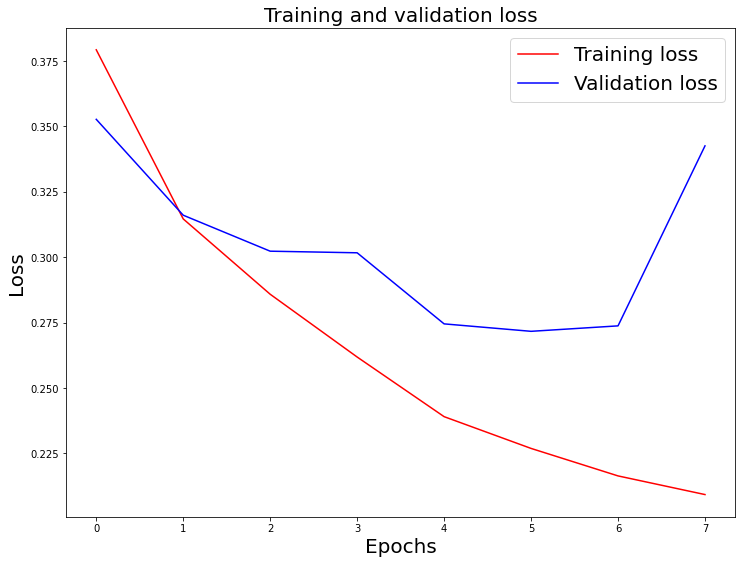

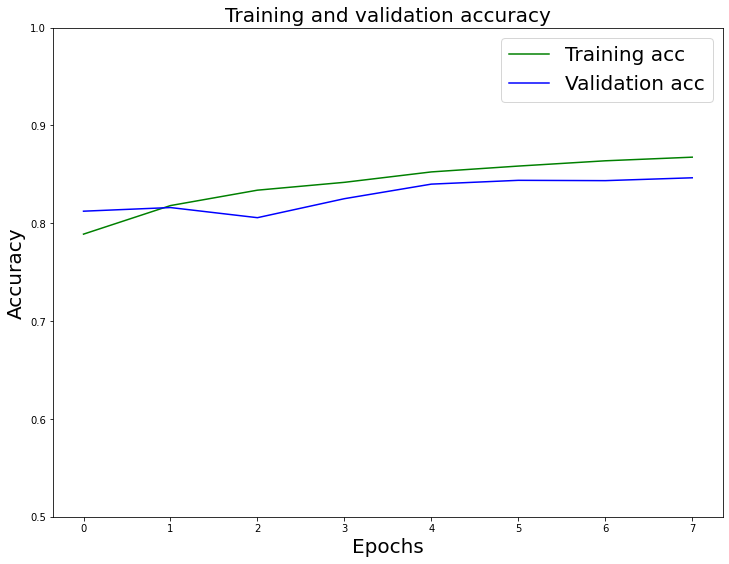

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

483/483 [==============================] - 9s 19ms/step - loss: 0.2795 - accuracy: 0.8414


[0.2795003652572632, 0.8414444923400879]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8414444732073518
Precision on testing set: 0.684226102397159
Recall on testing set: 0.9360323886639677


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 300,trainable=False,weights=[embedding_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        140544    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               14016     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1855/1855 [==============================] - 83s 41ms/step - loss: 0.3641 - accuracy: 0.7951 - val_loss: 0.2868 - val_accuracy: 0.8372
Epoch 2/10
1855/1855 [==============================] - 75s 41ms/step - loss: 0.2712 - accuracy: 0.8388 - val_loss: 0.2829 - val_accuracy: 0.8385
Epoch 3/10
1855/1855 [==============================] - 74s 40ms/step - loss: 0.2466 - accuracy: 0.8495 - val_loss: 0.2586 - val_accuracy: 0.8379
Epoch 4/10
1855/1855 [==============================] - 74s 40ms/step - loss: 0.2304 - accuracy: 0.8569 - val_loss: 0.2579 - val_accuracy: 0.8452
Epoch 5/10
1855/1855 [==============================] - 75s 41ms/step - loss: 0.2197 - accuracy: 0.8623 - val_loss: 0.2696 - val_accuracy: 0.8478
Epoch 6/10
1855/1855 [==============================] - 75s 40ms/step - loss: 0.2138 - accuracy: 0.8646 - val_loss: 0.2707 - val_accuracy: 0.8482


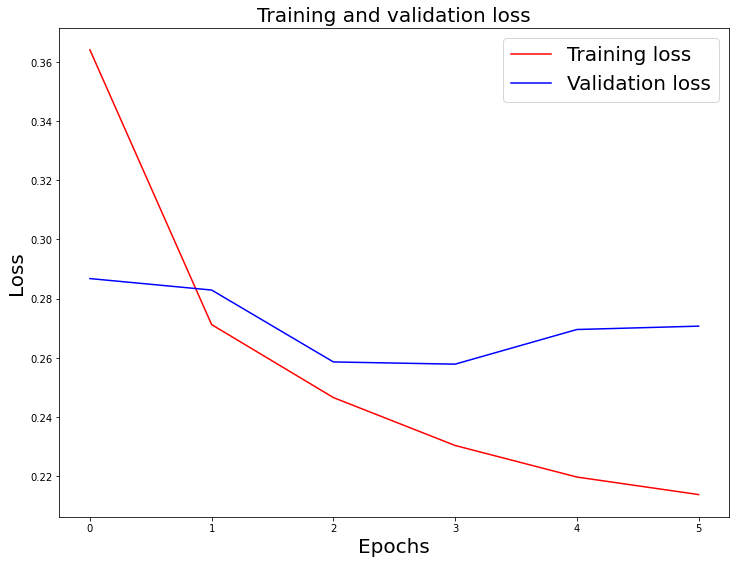

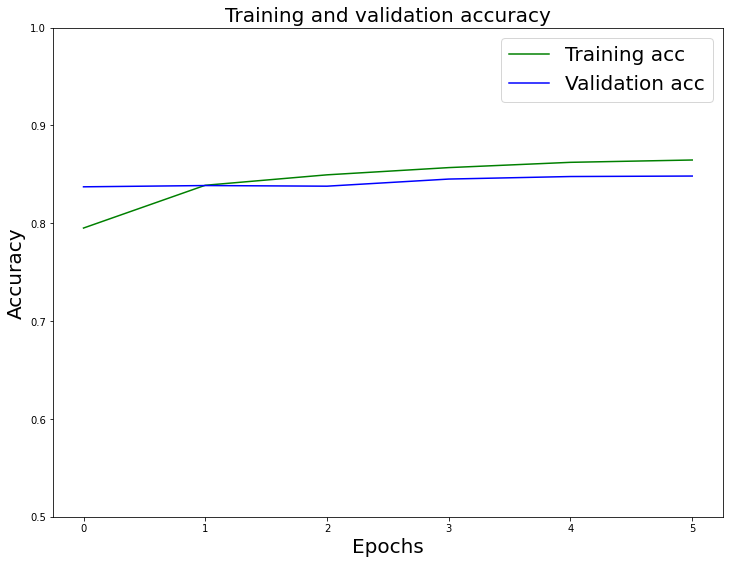

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

483/483 [==============================] - 9s 18ms/step - loss: 0.2660 - accuracy: 0.8417


[0.26595860719680786, 0.8417033553123474]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8417033393735439
Precision on testing set: 0.6638058597218112
Recall on testing set: 0.9626609442060086
